# A hidden Markov model for lymphatic tumour progression in head and neck cancer

Roman Ludwig¹*, Bertrand Pouymayou¹, Panagiotis Balermpas¹ and Jan Unkelbach¹

¹ Departement of Radiation Oncology, University Hospital Zurich, Switzerland \
\* [roman.ludwig@usz.ch](mailto:roman.ludwig@usz.ch)

***

## Abstract [🔗](https://www.nature.com/articles/s41598-021-91544-1)

Currently , elective clinical target volume (CTV-N) definition for head & neck squamous cell carcinoma (HNSCC) is mostly based on the prevalence of nodal involvement for a given tumor location. In this work, we propose a probabilistic model for lymphatic metastatic spread that can quantify the risk of microscopic involvement in lymph node levels (LNL) given the location of macroscopic metastases and T-stage. This may allow for further personalized CTV-N definition based on an individual patient’s state of disease. \
We model the patient's state of metastatic lymphatic progression as a collection of hidden binary random variables that indicate the involvement of LNLs. In addition, each LNL is associated with observed binary random variables that indicate whether macroscopic metastases are detected. A hidden Markov model (HMM) is used to compute the probabilities of transitions between states over time. The underlying graph of the HMM represents the anatomy of the lymphatic drainage system. Learning of the transition probabilities is done via Markov chain Monte Carlo sampling and is based on a dataset of HNSCC patients in whom involvement of individual LNLs was report-ed. \
The model is demonstrated for ipsilateral metastatic spread in oropharyngeal HNSCC patients. We demonstrate the model's capability to quantify the risk of microscopic involvement in levels III and IV, depending on whether macroscopic metastases are observed in the upstream levels II and III, and depending on T-stage. \
In conclusion, the statistical model of lymphatic progression may inform future, more personal-ized, guidelines on which LNL to include in the elective CTV. However, larger multi-institutional datasets for model parameter learning are required for that. 

***

## Introduction

This notebook contains all the code we ran to produce results and plots for our paper. It is intended to be read alongside the paper if one wants to understand better how exactly we implemented and used the methodology introduced in the paper. However, this notebook is NOT a stand-alone work but only a supplement.

### Imports

First, we import some libraries that are necessary for our implementation. [`lymph`](https://lymph-model.readthedocs.io/en/latest/) is the package we wrote, while [`corner`](https://corner.readthedocs.io/en/latest/) and [`emcee`](https://emcee.readthedocs.io/en/stable/) (see also the corresponding [arXiv paper](https://arxiv.org/abs/1202.3665) on this package) are both packages by Dan Foreman-Mackey & contributors. [`matplotlib`](https://matplotlib.org/stable/index.html) is an extensive and powerful plotting library. All other packages are standard and included with any default python installation.

In [1]:
# Additional requirements to install for running this notebook
!pip install -r notebook_requirements.txt

  Cloning https://github.com/rmnldwg/corner.py to /tmp/pip-install-k7rka_kw/corner_e80e119dfb984288a324f14ec6510019
  Running command git clone --filter=blob:none --quiet https://github.com/rmnldwg/corner.py /tmp/pip-install-k7rka_kw/corner_e80e119dfb984288a324f14ec6510019
  Resolved https://github.com/rmnldwg/corner.py to commit f3ef9497140143f3f5bc9c07b66c7efc8dc4127f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached matplotlib-3.5.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached jupyter_console-6.4.0-py3-none-any.whl (22 kB)
  Using cached qtconsole-5.2.2-py3-none-any.whl (120 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.29.1-py3-none-any.whl (895 kB)
  Using cached kiwisolver-1.3.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cach

In [1]:
# basic stuff
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
from multiprocessing import Pool
import datetime as dt

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from cycler import cycler
import corner

# sampling
import emcee

# our package
import lymph

## Settings

The variables below are meant to be constants. `MAX_T` is the length of the used binomial time-prior. `DRAW_SAMPLES` is a `bool` that defines whether new samples will be drawn for the plots and computations or alreadz drawn samples should be loaded from file. `SEED` is the seed for the random number generator in `numpy` and aims at reproducability. `SAVE_FIGURES` defines whether or not generated figures should be saved to disk.

In [2]:
MAX_T = 10
DRAW_SAMPLES = True
SEED = 42
SAVE_FIGURES = True

### Colors

We chose the colors of the University Hospital Zurich's corporate design for the default colors of our plots.

In [3]:
# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)
tmp = tmp(np.linspace(0., 1., 128))
tmp = np.vstack([np.array([gray_rgba]*128), tmp])
halfGray_halfGreenToRed = ListedColormap(tmp)

### Plot Settings

Here we define a function to consistently set the size of our plots and we load the default settings regarding font size etc from an `.mplstyle` file.

In [4]:
plt.style.use("./lymph.mplstyle")

def set_size(width="single", unit="cm", ratio="golden"):
    if width == "single":
        width = 10
    elif width == "full":
        width = 16
    else:
        try:
            width = width
        except:
            width = 10
            
    if unit == "cm":
        width = width / 2.54
        
    if ratio == "golden":
        ratio = 1.618
    else:
        ratio = ratio
    
    try:
        height = width / ratio
    except:
        height = width / 1.618
        
    return (width, height)

In [5]:
# only works on Windows when using WSL 2
font_dirs = ["/usr/share/fonts/truetype/dejavu", "/mnt/c/Windows/Fonts"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

## Data

The dataset we use here was reconstructed by [Pouymayou et al.](#pouymayou) from [Sanguineti et al.](#sanguineti). Here, it is loaded from file. Note that $N_0$ patients were added to make up 30% of the dataset.

In [6]:
# parameters and risk estimation from Pouymayou et al [2]
pouymayou_params = [0.061, 0.638, 0.094, 0.057, 0.08, 0.331, 0.242]
pouymayou_MLrisk = np.array([[ 1.53,  1.64,  1.66,  1.56], 
                             [24.67, 81.55, 89.64, 39.06], 
                             [ 4.48,  9.97, 59.93, 38.75], 
                             [ 1.83,  2.25,  6.05,  4.44]]) / 100.

# data reconstructed from Sanguineti et al [1] (without N0 patients)
data = pd.read_csv("./data/2009_sanguineti.csv", 
                   header=None, 
                   names=['I', 'II', 'III', 'IV'])

# inserting info about the "T-stage"
data.insert(0, "t_stage", ["early"] * data.shape[0])

columns = pd.MultiIndex.from_arrays([['info', 'path', 'path', 'path', 'path'], 
                                     ['t_stage', 'I', 'II', 'III', 'IV']])
data = pd.DataFrame(data.values.tolist(), columns=columns)
data.head()

info path          
  t_stage    I II III IV
0   early    1  0   0  0
1   early    0  1   0  0
2   early    0  1   0  0
3   early    0  1   0  0
4   early    0  1   0  0

> *__Table 1:__ Rows of patients and columns of T-stage, as well as nodal involvement patterns. Reconstructed from [[1]](#sanguineti).*

## Inference

In this section we will set up everything necessary to perform inference on the dataset recostructed by [[2]](#pouymayou) from [[1]](#sanguineti).

### Lymphatic Network

Here, we need to define the underlying anatomical network of lymph node levels (LNLs), as it is also defined in [[2]](#pouymayou). 

The tumor and every LNL are represented by a key in a dictionary called `graph` each. The respective value in the dictionary is a list of nodes it drains to.

In [8]:
# abstract representation of the lymphatic network
graph = {('tumor', 'primary')  : ['I', 'II', 'III', 'IV'], 
         ('lnl', 'I')          : ['II'], 
         ('lnl', 'II')         : ['III'], 
         ('lnl', 'III')        : ['IV'], 
         ('lnl', 'IV')         : []}

model = lymph.System(graph=graph)

### Time Prior
We need to choose a time prior for the parameter learning. A [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) was chosen for its intuitively meaningful shape and simple structure.

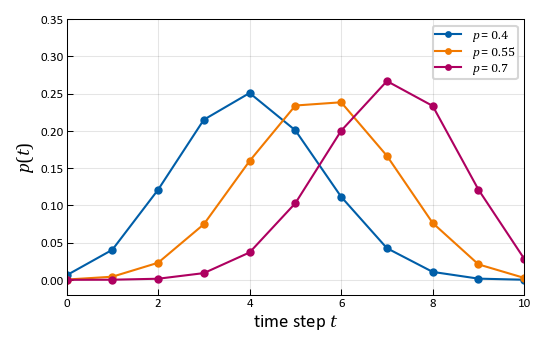

In [10]:
fig, ax = plt.subplots(figsize=set_size());

for i,p in enumerate([0.4, 0.55, 0.7]):
    ax.plot(np.arange(MAX_T+1), 
            sp.stats.binom.pmf(np.arange(MAX_T+1), MAX_T, p), 
            "o-", label=f"$p = {{{p}}}$")
    
ax.set_xlim([0,10]);
ax.set_ylim([-0.02,0.35])
ax.set_xlabel("time step $t$");
ax.set_ylabel(r"$p(t)$");
ax.tick_params();
ax.legend();

> *__Figure 1:__ Binomial distribution with three different p-parameters. They represent the probability of diagnosis at time-step $t$ for three different scenarios, like T-category.*

In [11]:
# creating a dictionary of time priors for the sampling process
p_early = 0.4
time_dists = {}
time_dists["early"] = sp.stats.binom.pmf(np.arange(MAX_T+1), MAX_T, p_early)

### Learning (HMM)

Using the anatomical model along with the data, we can now load the data into the lymph system class. To do so we must first assign a dictionary called `modality_spsn` to the lymphatic system or pass it together with the data in the `load_data` method. **``spsn``** stands for **sp**ecificity and **s**e**n**sitivity. In that dictionary, one has to define a list ``[specificty, sensitivity]`` for each diagnostic modality one is interested in. So if we, for example, have MRI and CT data, then we would pass a dictionary like this:

```python
modality_spsn = {
    "MRI": [spec_MRI, sens_MRI], 
    "CT" : [spec_CT , sens_CT ]
}
```

Note however, that the keys of this dictionary must be diagnostic modalities that are also present in the dataset. More precisely, they must be the overarching categories in the ``MultiIndex`` under which one then finds the individual LNLs.

Finally, we can use the likelihood function that is built into the `lymph` package together with the sampling implementation `emcee` to infer the base probabilities $b_{v}$ and transition probabilities $t_{\operatorname{pa}(v) \rightarrow v}$.

In [14]:
# define specificity and sensitivity for diagnostic modalities
modality_spsn = {"path": [1., 1.]}
model.modalities = modality_spsn

# load data
model.patient_data = data

# check if likelihood works
spread_probs = np.random.uniform(size=(7,))
llh = model.log_likelihood(
    spread_probs, t_stages=["early"], 
    time_dists=time_dists, 
    mode="HMM"
)
print(llh)

-856.0005867317035


In [17]:
# parameters of the sampler
ndim, nwalker, nstep, burnin = 7, 200, 2000, 1000
moves = [(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)]

if DRAW_SAMPLES:
    # starting point
    np.random.seed(SEED)
    initial_spread_probs = np.random.uniform(low=0., high=1., size=(nwalker,ndim))

    # the actual sampling round
    if __name__ == "__main__":
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(
                nwalker, ndim, 
                model.log_likelihood, 
                kwargs={"t_stages": ["early"], "time_dists": time_dists}, 
                moves=moves, pool=pool
            )
            sampler.run_mcmc(initial_spread_probs, nstep, progress=True)

    # extracting 200,000 of the 400,000 samples
    samples_HMM = sampler.get_chain(flat=True, discard=burnin)

    # saving the sampled data to disk for later convenience
    np.save("./samples/HMM.npy", samples_HMM)
    
else:
    # loading in case we don't want to draw all the samples again
    samples_HMM = np.load("./samples/HMM.npy")

100%|██████████| 2000/2000 [01:52<00:00, 17.77it/s]


In [18]:
if DRAW_SAMPLES:
    # check acceptance faction of the sampler to get an indication on whether sth
    # went wrong or not
    ar = np.mean(sampler.acceptance_fraction)
    print(f"the HMM sampler accepted {ar * 100 :.2f} % of samples.")

the HMM sampler accepted 30.67 % of samples.


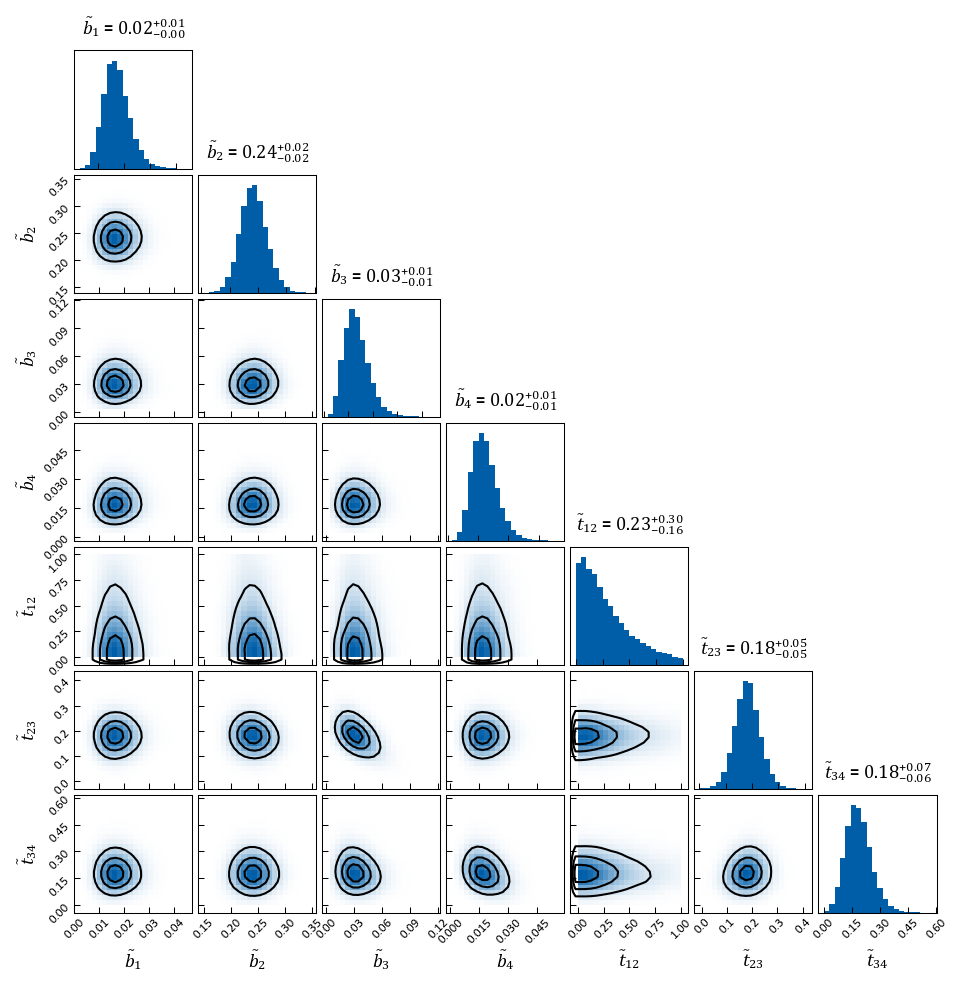

In [19]:
labels = [r"$\tilde{b}_1$", r"$\tilde{b}_2$", 
          r"$\tilde{b}_3$", r"$\tilde{b}_4$", 
          r"$\tilde{t}_{12}$", r"$\tilde{t}_{23}$", r"$\tilde{t}_{34}$"]

fig = plt.figure(figsize=set_size(width="full", ratio=1))

# using the corner plot package
corner.corner(samples_HMM, labels=labels, smooth=True, fig=fig, 
              hist_kwargs={'histtype': 'stepfilled', 'color': usz_blue}, 
              **{'plot_datapoints': False, 'no_fill_contours': True, 
                 "density_cmap": white_to_blue.reversed(), 
                 "contour_kwargs": {"colors": "k"}, 
                 "levels": np.array([0.2, 0.5, 0.8])}, 
              show_titles=True, title_kwargs={"fontsize": "medium"});

axes = fig.get_axes()
for ax in axes:
    ax.grid(False)
    
if SAVE_FIGURES:
    plt.savefig("./figures/corner_HMM.png", dpi=300, bbox_inches="tight")
    plt.savefig("./figures/corner_HMM.svg", bbox_inches="tight")

> *__Figure 2:__ Corner plot of the sampled parameters for the HMM model parameters. The histograms on the diagonal show the 1D marginals, while the lower triangle shows all possible combinations of 2D marginals. The black lines are the isolines enclosing 20%, 50% and 80% of the sampled points respectively. Correlations between the parameters can at most be seen between $\tilde{t}_{23}$ and $\tilde{b}_3$.*

### Transition Matrix

We can now set the hidden Markov model's parameters to the expected value of the inferred parameters and look at the resulting transition matrix $\mathbf{A}$.

/home/rmnldwg/repos/lymph/.venv/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


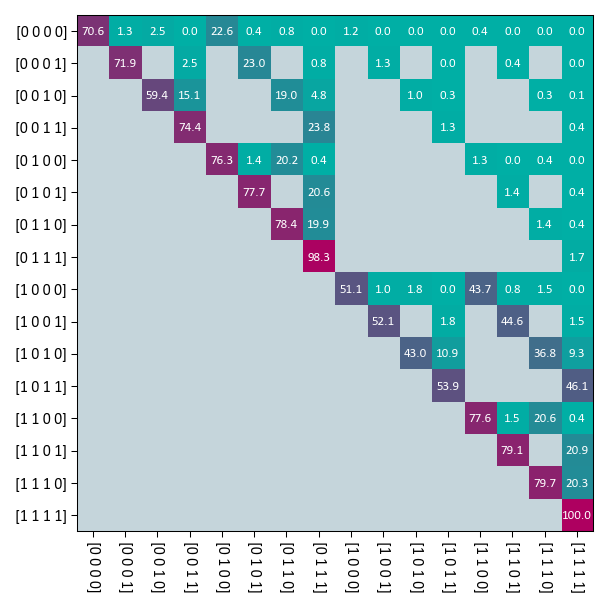

In [20]:
# set the parameters
model.spread_probs = np.mean(samples_HMM, axis=0)

# modify the transition matrix for nicer coloring
mod_A = -1 * np.ones_like(model.transition_matrix)
for key, nums in model.allowed_transitions.items():
    for i in nums:
        mod_A[key, i] = model.transition_matrix[key, i]

# plot the transition matrix
fig, ax = plt.subplots(figsize=set_size(ratio=1.), 
                       constrained_layout=True);

h = ax.imshow(mod_A, cmap=halfGray_halfGreenToRed, vmin=-1., vmax=1.);
ax.set_xticks(range(len(model.state_list)));
ax.set_xticklabels(model.state_list, rotation=-90, fontsize="small");
ax.set_yticks(range(len(model.state_list)));
ax.set_yticklabels(model.state_list, fontsize="small");
ax.tick_params(direction="out")
ax.grid(False)

# label the non-zero entries with their probability in %
for i in range(len(model.state_list)):
    for j in range(len(model.state_list)):
        if mod_A[i,j] > 0.:
            ax.text(j,i, f"{mod_A[i,j]*100:.1f}", ha="center", va="center", 
                    color="white", fontsize="x-small")
            
if SAVE_FIGURES:
    plt.savefig("./figures/transition_matrix.png", dpi=300, bbox_inches="tight")
    plt.savefig("./figures/transition_matrix.svg", bbox_inches="tight")

> *__Figure 3:__ Transition matrix $\mathbf{A}$. All gray pixels in this image correspond to entries in the matrix being zero. The colored pixels take on values $\in [0,1]$ which are here overlayed in %. The exact values stem from the mean of the learned parameters displayed above. The exact shape of the grey “mask” depends on how one orders the states*

### Evolution Plots

We can also take a look at how this system evolves over the defined time steps.

In [21]:
# array containing the risk for each state...
state_array = np.zeros(shape=(MAX_T+1, len(model.state_list)), dtype=float)
# ...weighted with the probability for that time
state_array_weighted = np.zeros_like(state_array, dtype=float)
state_array_summed = np.zeros_like(state_array, dtype=float)
# starting state
start = np.zeros(shape=(len(model.state_list),))
start[0] = 1.

# manually evolving the system and storing all intermediate states
time_dist = sp.stats.binom.pmf(np.arange(MAX_T+1), MAX_T, 0.4)
for t,p in enumerate(time_dist):
    state_array[t] = start
    state_array_weighted[t] = p * start
    state_array_summed[t] = np.ones(shape=(1,t+1)) @ state_array_weighted[:t+1]
    state_array_summed[t] = state_array_summed[t] / np.sum(state_array_summed[t])
    start = start @ model.transition_matrix

In [22]:
# these arrays define which states we need to marginalize over when we are 
# interested in a particual LNL's risk of involvement
lnl_I_arr = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 
                     dtype=float)
lnl_II_arr = np.array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], 
                      dtype=float)
lnl_III_arr = np.array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1], 
                       dtype=float)
lnl_IV_arr = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], 
                      dtype=float)

lnl_I = state_array @ lnl_I_arr
lnl_II = state_array @ lnl_II_arr 
lnl_III = state_array @ lnl_III_arr 
lnl_IV = state_array @ lnl_IV_arr

lnl_concat = np.vstack([lnl_I, lnl_II, lnl_III, lnl_IV])

In [23]:
marg_II = np.zeros(shape=(len(samples_HMM[::50])))
marg_III = np.zeros(shape=(len(samples_HMM[::50])))
marg_II_and_III = np.zeros(shape=(len(samples_HMM[::50])))
marg_IV = np.zeros(shape=(len(samples_HMM[::50])))

np.random.seed(SEED)
for i, spread_probs in enumerate(np.random.permutation(samples_HMM[::50])):
    model.spread_probs = spread_probs
    marg_II[i] = 100 * model.risk(
        inv=np.array([None, 1, None, None]),
        diagnoses={"path": np.array([None, None, None, None])},
        time_dist=time_dist
    )
    marg_III[i] = 100 * model.risk(
        inv=np.array([None, None, 1, None]),
        diagnoses={"path": np.array([None, None, None, None])},
        time_dist=time_dist
    )
    marg_II_and_III[i] = 100 * model.risk(
        inv=np.array([None, 1, 1, None]),
        diagnoses={"path": np.array([None, None, None, None])},
        time_dist=time_dist
    )
    marg_IV[i] = 100 * model.risk(
        inv=np.array([None, None, None, 1]),
        diagnoses={"path": np.array([None, None, None, None])},
        time_dist=time_dist
    )

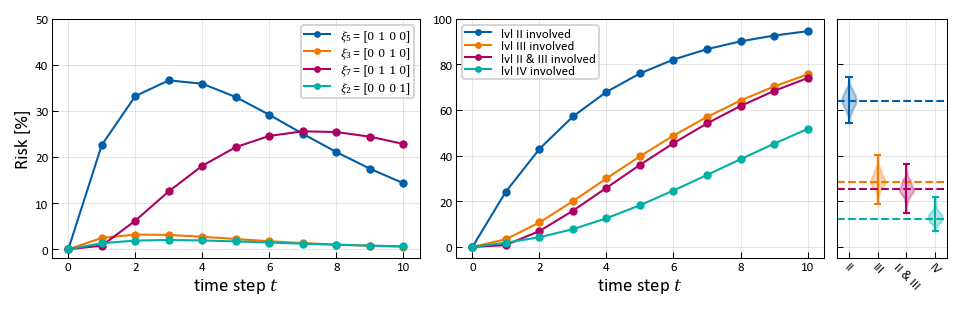

In [24]:
# marginalization for involvements of "at least LNL x" or "only LNL x" 
only_II = state_array[:,4]
atleast_II = (state_array[:,4] + state_array[:,5] + state_array[:,6] 
              + state_array[:,7] + state_array[:,12] + state_array[:,13] 
              + state_array[:,14] + state_array[:,15])
emp_II = 100 * np.sum(data[("path", 'II')].to_numpy()) / 147

only_III = state_array[:,2]
atleast_III = (state_array[:,2] + state_array[:,3] + state_array[:,6] 
               + state_array[:,7] + state_array[:,10] + state_array[:,11] 
               + state_array[:,14] + state_array[:,15])
emp_III = 100 * np.sum(data[("path", 'III')].to_numpy()) / 147

only_II_and_III = state_array[:,6]
atleast_II_and_III = (state_array[:,6] + state_array[:,7] 
                      + state_array[:,14] + state_array[:,15])
emp_II_and_III = 100 * len(data.loc[(data[("path", 'II')]==1) 
                                    & (data[("path", 'III')]==1)].to_numpy()) / 147

only_IV = state_array[:,1]
atleast_IV = (state_array[:,1] + state_array[:,3] + state_array[:,5] 
              + state_array[:,7] + state_array[:,9] + state_array[:,11] 
              + state_array[:,13] + state_array[:,15])
emp_IV = 100 * np.sum(data[("path", 'IV')].to_numpy()) / 147

# and now for one complicated plot...
fig = plt.figure(figsize=set_size(width="full", ratio=2*1.61), 
                 constrained_layout=True);
spec = gs.GridSpec(ncols=3, nrows=1, figure=fig, width_ratios=[1., 1., 0.3]);

# leftmost subplot
ax = fig.add_subplot(spec[0,0])
ax.plot(range(len(time_dist)), 100*only_II, 'o-', 
        label=r"$\xi_5=[0\ 1\ 0\ 0]$");
ax.plot(range(len(time_dist)), 100*only_III, 'o-', 
        label=r"$\xi_3=[0\ 0\ 1\ 0]$");
ax.plot(range(len(time_dist)), 100*only_II_and_III, 'o-', 
        label=r"$\xi_7=[0\ 1\ 1\ 0]$");
ax.plot(range(len(time_dist)), 100*only_IV, 'o-', 
        label=r"$\xi_2=[0\ 0\ 0\ 1]$");
ax.set_xlabel("time step $t$");
ax.set_ylim(ymax=50);
ax.set_ylabel("Risk [%]");
ax.legend();

# middle subplot
ax = fig.add_subplot(spec[0,1])
ax.plot(range(len(time_dist)), 100*atleast_II, 'o-', 
        label="lvl II involved");
ax.plot(range(len(time_dist)), 100*atleast_III, 'o-', 
        label="lvl III involved");
ax.plot(range(len(time_dist)), 100*atleast_II_and_III, 'o-', 
        label="lvl II & III involved");
ax.plot(range(len(time_dist)), 100*atleast_IV, 'o-', 
        label="lvl IV involved");
ax.set_xlabel("time step $t$");
ax.set_ylim(ymax=100);
ax.legend();

# rightmost subplot
ax = fig.add_subplot(spec[0,2], sharey=ax);
plt.setp(ax.get_yticklabels(), visible=False);
ax.set_xticks([0, 1, 2, 3]);
ax.set_xticklabels(["II", "III", "II & III", "IV"], rotation=-45);

violin = ax.violinplot(marg_II, positions=[0]);
violin["bodies"][0].set_color(usz_blue);
violin["cbars"].set_color(usz_blue);
ax.axhline(emp_II, color=usz_blue, ls="--");

violin = ax.violinplot(marg_III, positions=[1]);
violin["bodies"][0].set_color(usz_orange);
violin["cbars"].set_color(usz_orange);
ax.axhline(emp_III, color=usz_orange, ls="--");

violin = ax.violinplot(marg_II_and_III, positions=[2]);
violin["bodies"][0].set_color(usz_red);
violin["cbars"].set_color(usz_red);
ax.axhline(emp_II_and_III, color=usz_red, ls="--");

violin = ax.violinplot(marg_IV, positions=[3]);
violin["bodies"][0].set_color(usz_green);
violin["cbars"].set_color(usz_green);
ax.axhline(emp_IV, color=usz_green, ls="--");

if SAVE_FIGURES:
    plt.savefig("./figures/HMM_evolution.png", dpi=300, bbox_inches="tight")
    plt.savefig("./figures/HMM_evolution.svg", bbox_inches="tight")

> *__Figure 3:__ (left) Probability of certain hidden state vs time; (middle) Probability of LNL’s involvement marginalized over the other LNL’s involvement vs time; (right) The same probabilities as in the middle, but also marginalized over the time-prior and depicted as violin plots. The dashed lines represent the prevalence in the dataset8 that was used for training.*

/home/rmnldwg/repos/lymph/.venv/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/rmnldwg/repos/lymph/.venv/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


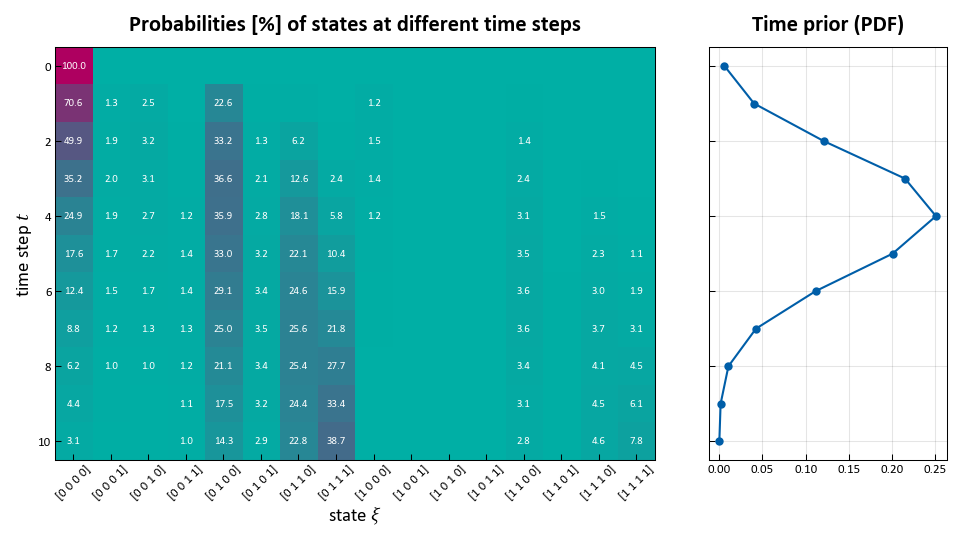

In [25]:
fig = plt.figure(figsize=set_size(width="full", ratio=1.8), 
                 constrained_layout=True)
spec = gs.GridSpec(ncols=2, nrows=1, figure=fig, 
                   width_ratios=[1., 0.35], height_ratios=[1.])

ax_im = fig.add_subplot(spec[0,0])
ax_im.set_title("Probabilities [%] of states at different time steps")
ax_im.imshow(state_array, cmap=green_to_red);
for i in range(len(time_dist)):
    for j in range(len(model.state_list)):
        if np.around(state_array[i,j]*100,1) >= 1.:
            ax_im.text(j,i, f"{state_array[i,j]*100:.1f}", 
                       ha="center", va="center", 
                       color="white", fontsize="xx-small")
ax_im.set_xticks(range(len(model.state_list)))
ax_im.set_xticklabels(model.state_list, rotation=45);
ax_im.set_ylabel("time step $t$")
ax_im.set_xlabel(r"state $\xi$")
ax_im.grid(False)

ax_pr = fig.add_subplot(spec[0,1], sharey=ax_im)
ax_pr.set_title("Time prior (PDF)")
ax_pr.plot(time_dist, range(len(time_dist)), "o-")
plt.setp(ax_pr.get_yticklabels(), visible=False);

if SAVE_FIGURES:
    plt.savefig("./figures/HMM_evo_matrix.png", dpi=300, bbox_inches="tight")
    plt.savefig("./figures/HMM_evo_matrix.svg", bbox_inches="tight")

> *__Figure 4:__ Probability of being in each hidden state as a function of time (left). The color indicates low (green) and high (red) probabilities, which are also written on the respective pixel in percent if larger than 1%. We used the mean of the inferred parameter samples to compute the probabilities. On the right, the used time-prior is plotted with which each column on the left will be weighted.*

## (Cross-)Validation

### Comparison of risk & prevalences

As an attempt to validate the model with the limited data we have, I'll start by simply comparing the prevalence of certain patterns of involvement to the prediction of the model for the respective state.

In [26]:
thin = 100
np.random.seed(SEED)

risks = np.zeros(shape=(len(model.obs_list), len(samples_HMM[::thin])), dtype=float)

for i, sample in enumerate(np.random.permutation(samples_HMM[::thin])):
    for j, obs in enumerate(model.obs_list):
        model.spread_probs = sample
        risks[j,i] = model.risk(
            inv=obs, diagnoses={"path": [None, None, None, None]}, 
            time_dist=time_dists["early"], mode="HMM"
        )

In [30]:
occurences, _ = lymph.utils.comp_state_dist(data["path"].values)

validation_df = pd.DataFrame({"state": [str(obs) for obs in model.obs_list], 
                              "occurence": occurences, 
                              "percentage": 100 * occurences / np.sum(occurences), 
                              "prediction": 100 * np.mean(risks, axis=1)})
validation_df.head()

,state,occurence,percentage,prediction
0,[0 0 0 0],44,29.931973,28.486387
1,[0 0 0 1],1,0.680272,1.780765
2,[0 0 1 0],4,2.721088,2.569143
3,[0 0 1 1],1,0.680272,1.023521
4,[0 1 0 0],53,36.054422,33.515116


> *__Table 2:__ Prevalence of each state in the dataset (column "percentage") and the corresponding prediction from the model (column "prediction").*

### 3-fold cross-validation

Now I will split the dataset randomly into three equally large parts. Then I will train the model on all three combinations of two of these thirds and compare them to the respectively remaining third to see if the results are still plausible.

These results are actually not in our paper, since they were already done in a similar fashion by Pouymayou et al.

In [31]:
subsets = []

# first third
subsets.append(data.sample(frac=1./3.))
rest = data.drop(subsets[0].index)

# second third
subsets.append(rest.sample(frac=0.5))

# third third
subsets.append(rest.drop(subsets[1].index))

In [32]:
for i,subset in enumerate(subsets):
    subset.to_csv(f"./data/cross-validation_set{i+1}.csv")

In [ ]:
# parameters of the sampler
cross_validation_samples = []
ndim, nwalker, nstep, burnin = 7, 200, 2000, 1000
moves = [(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)]
np.random.seed(SEED)

if DRAW_SAMPLES:
    for i,subset in enumerate(subsets):
        # load data subset (or rather the remainder)
        model.patient_data = data.drop(subset.index)

        # starting point
        theta0 = np.random.uniform(low=0., high=1., size=(nwalker,ndim))

        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalker, ndim, model.log_likelihood, 
                                            args=[["early"], time_dists], 
                                            moves=moves, pool=pool)
            sampler.run_mcmc(theta0, nstep, progress=True)

        cross_validation_samples.append(
            sampler.get_chain(flat=True, discard=burnin)
        )
        
        # saving the sampled data to disk for later convenience
        np.save(f"./samples/cross-validation-samples{i+1}.npy", 
                cross_validation_samples[i])
    
else:
    for i,subset in enumerate(subsets):
        # loading in case we don't want to draw all the samples again
        cross_validation_samples.append(
            np.load(f"./samples/cross-validation-samples{i+1}.npy")
        )

Now I will plot the results

In [28]:
systm.load_data(data, t_stages=["early"],
                modality_spsn=modality_spsn, mode="HMM",
                gen_C_kwargs={"delete_ones": False})

C_total = systm.C_dict["early"]
f_total = systm.f_dict["early"]

C_matrices = []
f_vectors = []

for i,subset in enumerate(subsets):
    systm.load_data(subset, t_stages=["early"],
                    modality_spsn=modality_spsn, mode="HMM",
                    gen_C_kwargs={"delete_ones": False})
    C_matrices.append(systm.C_dict["early"])
    f_vectors.append(systm.f_dict["early"])

In [29]:
cross_val = pd.DataFrame(columns=["subset 1", "subset 2", "subset 3", "total"])

In [30]:
# go through all the states
for s in range(16):
    new_row = {}
    try:
        idx = np.where(C_total[s,:])[0][0]
        new_row["total"] = f_total[idx]
    except IndexError:
        new_row["total"] = 0
    for i in range(3):
        try:
            idx = np.where(C_matrices[i][s,:])[0][0]
            new_row[f"subset {i+1}"] = f_vectors[i][idx]
        except IndexError:
            new_row[f"subset {i+1}"] = 0
        
    cross_val = cross_val.append(new_row, ignore_index=True)

In [31]:
obs_spsn_dict = {"PET": [0.86, 0.79]}
systm.modalities = obs_spsn_dict

In [32]:
thin = 500
state_list = systm.state_list
risk_matrix = np.zeros(shape=(16,4,int(samples_HMM.shape[0]/thin)), dtype=float)

for s,state in enumerate(state_list):
    for i,sample in enumerate([cross_validation_samples[0], 
                               cross_validation_samples[1], 
                               cross_validation_samples[2], 
                               samples_HMM]):
        sample_set = np.random.permutation(sample)[::thin]
        risk_matrix[s,i] = [
            systm.risk(
                val, inv=state, 
                time_dist=time_dists["early"]) for val in sample_set
        ]

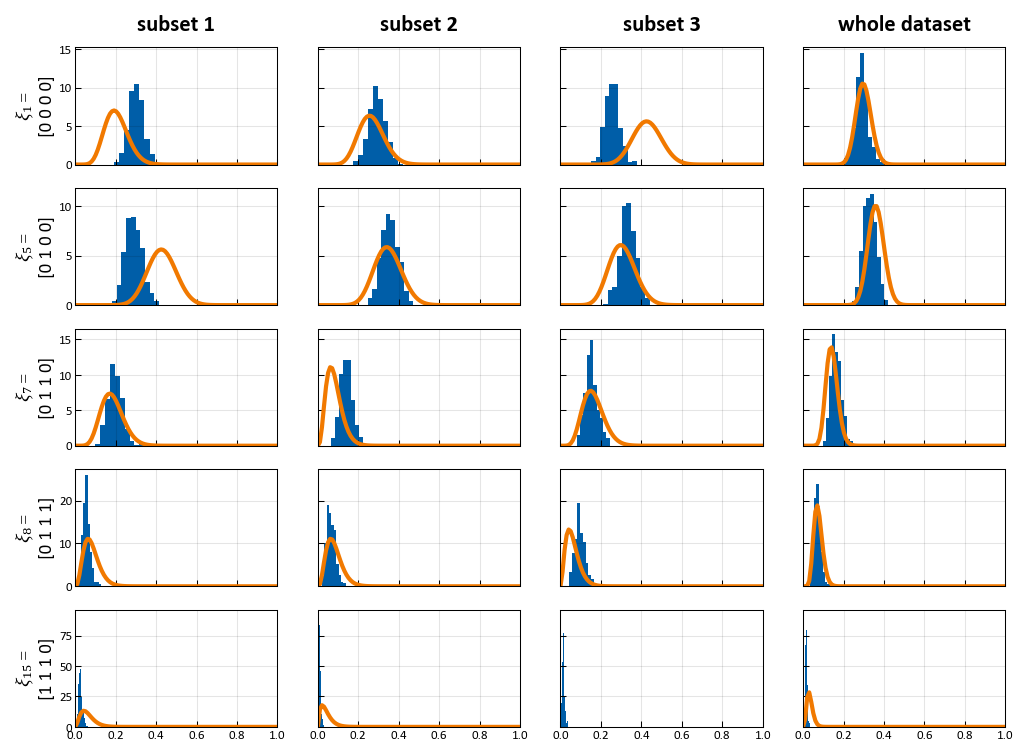

In [33]:
# select the most interesting states (others have very small probabilities)
row_selection = [0, 4, 6, 7, 14]
titles = ["subset 1", "subset 2", "subset 3", "whole dataset"]

fig, ax = plt.subplots(len(row_selection),4, figsize=(8,6), 
                       sharex="col", sharey="row")
x = np.linspace(0., 1., 100)

for s,row in enumerate(row_selection):
    for i,subset in enumerate([*subsets, data]):
        if s == 0:
            ax[s,i].set_title(titles[i])
        if i == 0:
            ax[s,i].set_ylabel(f"$\\xi_{{{row+1}}}=$\n{state_list[row]}")
        
        ax[s,i].plot(x, sp.stats.beta.pdf(x, 
                                          a=cross_val.iloc[row,i], 
                                          b=len(subset)-cross_val.iloc[row,i]), 
                     color=usz_orange, linewidth=2)
        ax[s,i].hist(risk_matrix[row,i], bins=10, density=True, 
                     histtype="stepfilled", color=usz_blue)
        ax[s,i].set_xlim([0., 1.])

> *__Figure 5:__ Histograms over predicted risk of certain states (blue) compared to the Beta distribution over the same risk, resulting from the prevalence of the respective state in the dataset (orange). This is plotted for the three subsets of the 3-fold cross-validation as well as the whole dataset.*

## Comparison to Bayesian Network

To be able to compare our results to the Bayesian network by [Pouymayou et al.](#pouymayou) we needed to recreate it using the same sampler. To this end, the `lymph` package also supports computing the Bayesian network likelihood for a given graph and observational modality.

In [10]:
# abstract representation of the lymphatic network
graph = {('tumor', 'primary')  : ['I', 'II', 'III', 'IV'], 
         ('lnl', 'I')          : ['II'], 
         ('lnl', 'II')         : ['III'], 
         ('lnl', 'III')        : ['IV'], 
         ('lnl', 'IV')         : []}

model = lymph.System(graph=graph)

### Learning (BN)

All that is different to the learning round [above](#Learning-(HMM)) is that one has to specify the `mode` to be `"BN"` instead of `"HMM"`.

In [11]:
# define specificity and sensitivity for diagnostic modalities
modality_spsn = {"path": [1., 1.]}

model.modalities = modality_spsn

# generate C matrix from data
model.load_data(data, mode="BN")

# check if likelihood works
llh = model.log_likelihood(np.random.uniform(size=(7,)), mode="BN")
print(llh)

-626.0496357392176


In [12]:
# parameters of the sampler
ndim, nwalker, nstep, burnin = 7, 200, 2000, 1000
moves = [(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)]

if DRAW_SAMPLES:
    # starting point
    np.random.seed(SEED)
    initial_spread_probs = np.random.uniform(low=0., high=1., size=(nwalker,ndim))

    # the actual sampling round
    if __name__ == "__main__":
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(
                nwalker, ndim, 
                model.log_likelihood, kwargs={"mode": "BN"},
                moves=moves, pool=pool
            )
            sampler.run_mcmc(initial_spread_probs, nstep, progress=True)

    # extracting 200,000 of the 400,000 samples
    samples_BN = sampler.get_chain(flat=True, discard=burnin)

    # saving the sampled data to disk for later convenience
    np.save("./samples/BN.npy", samples_BN)
    
else:
    # loading in case we don't want to draw all the samples again
    samples_BN = np.load("./samples/BN.npy")

100%|██████████| 2000/2000 [01:21<00:00, 24.54it/s]


In [13]:
if DRAW_SAMPLES:
    # check acceptance faction of the sampler to get an indication on whether sth
    # went wrong or not
    ar = np.mean(sampler.acceptance_fraction)
    print(f"the BN sampler accepted {ar * 100 :.2f} % of samples.")

the BN sampler accepted 34.12 % of samples.


findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'monospace' not found because none of the following families were found: Ubuntu Mono


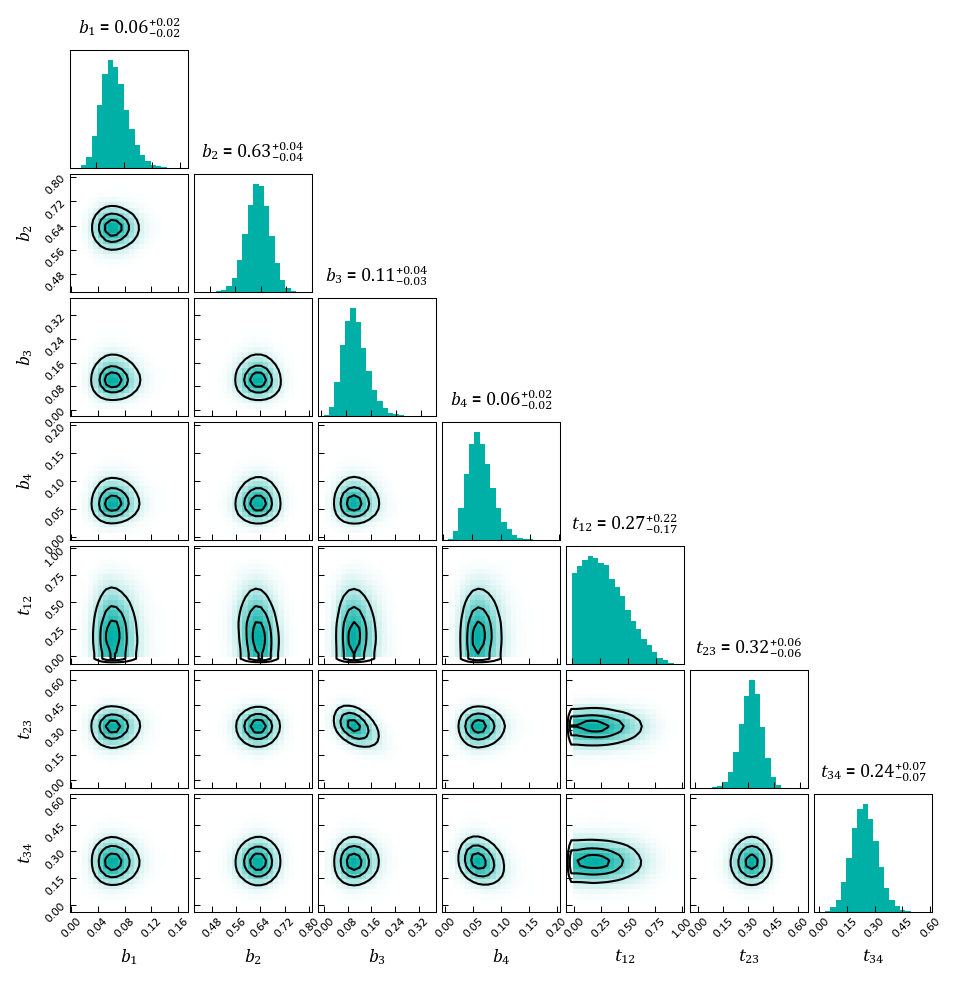

In [14]:
labels = [r"$b_1$", r"$b_2$", r"$b_3$", r"$b_4$", 
          r"$t_{12}$", r"$t_{23}$", r"$t_{34}$"]

fig = plt.figure(figsize=set_size(width="full", ratio=1))

# using the corner plot package
corner.corner(samples_BN, labels=labels, smooth=True, fig=fig, 
              hist_kwargs={'histtype': 'stepfilled', 'color': usz_green}, 
              **{'plot_datapoints': False, 'no_fill_contours': True, 
                 "density_cmap": white_to_green.reversed(), 
                 "contour_kwargs": {"colors": "k"}, 
                 "levels": np.array([0.2, 0.5, 0.8])}, 
              show_titles=True, title_kwargs={"fontsize": "medium"});

axes = fig.get_axes()
for ax in axes:
    ax.grid(False)
    
if SAVE_FIGURES:
    plt.savefig("./figures/corner_BN.png", dpi=300, bbox_inches="tight")
    plt.savefig("./figures/corner_BN.svg", bbox_inches="tight")

> *__Figure 6:__ Corner plor of sampled parameters using the Bayesian network model. Qualitatively, this looks very similar to Figure 2, but since the HMM model works with rates instead of absolute probabilities, the values here are larger.*

## Risk Predictions

We can now compute distributions over risks using both the HMM model, as well as the BN.

### Evolving beyond "early" T-stage

We can use the parameters inferred from the early T-stage dataset and use time priors that expect to see a patient's diagnose later on to estimate how risks of involvement might increase over time.

In [15]:
# abstract representation of the lymphatic network
graph = {('tumor', 'primary')  : ['I', 'II', 'III', 'IV'], 
         ('lnl'  , 'I')        : ['II'], 
         ('lnl'  , 'II')       : ['III'], 
         ('lnl'  , 'III')      : ['IV'], 
         ('lnl'  , 'IV' )      : []}

tst_model = lymph.System(graph=graph)

# set specificity & sensitivity of diagnostic modality (here CT) manually
ct_spsn = {"CT": [0.76, 0.81]}
tst_model.modalities = ct_spsn

In [18]:
# time priors
time_dists = {}
time_dists['early'] = sp.stats.binom.pmf(np.arange(MAX_T+1), MAX_T, 0.4)
time_dists['mid'] = sp.stats.binom.pmf(np.arange(MAX_T+1), MAX_T, 0.55)
time_dists['late'] = sp.stats.binom.pmf(np.arange(MAX_T+1), MAX_T, 0.7)

# what do we want to know, what do we know?
inv = np.array([None, None, 1, None])  # we're interested in the risk of LNL 3
# our observation is that lvl 2 is involved
diagnoses = {"CT": np.array([0, 1, 0, 0])}

thin = 50
# risk for HMM and different "T-stages"
early = []
mid = []
late = []
np.random.seed(SEED)
for sample in np.random.permutation(samples_HMM)[::thin]:
    tst_model.spread_probs = sample
    early.append(
        tst_model.risk(
            inv=inv, diagnoses=diagnoses, 
            time_dist=time_dists["early"], 
            mode="HMM"
        )
    )
    mid.append(
        tst_model.risk(
            inv=inv, diagnoses=diagnoses, 
            time_dist=time_dists["mid"], 
            mode="HMM"
        )
    )
    late.append(
        tst_model.risk(
            inv=inv, diagnoses=diagnoses, 
            time_dist=time_dists["late"], 
            mode="HMM"
        )
    )

# risk for BN
bn = []
np.random.seed(SEED)
for sample in np.random.permutation(samples_BN)[::thin]:
    tst_model.spread_probs = sample
    bn.append(tst_model.risk(inv=inv, diagnoses=diagnoses, mode="BN"))

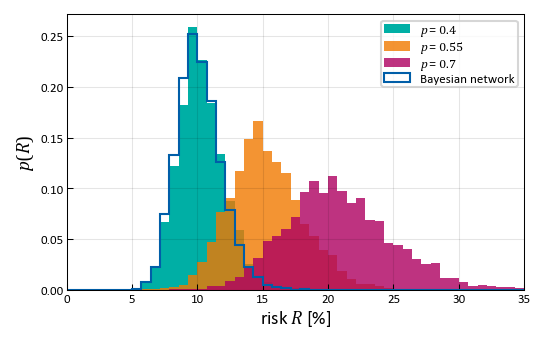

In [19]:
bins = np.linspace(0, 35, 50)
r = (0, 35)
fig, ax = plt.subplots(figsize=set_size())

ax.hist(np.asarray(early)*100., bins=bins, density=True, 
        histtype="stepfilled", color=usz_green, label="$p = 0.4$");
ax.hist(np.asarray(mid)*100., bins=bins, density=True, alpha=0.8, 
        histtype="stepfilled", color=usz_orange, label="$p = 0.55$");
ax.hist(np.asarray(late)*100., bins=bins, density=True, alpha=0.8, 
        histtype="stepfilled", color=usz_red, label="$p = 0.7$");
ax.hist(np.asarray(bn)*100., bins=bins, histtype="step", density=True, 
        color=usz_blue, label="Bayesian network");

ax.set_xlim(r)
ax.set_xlabel("risk $R$ [%]");
ax.set_ylabel(r"$p(R)$");
ax.tick_params();
ax.legend();

if SAVE_FIGURES:
    plt.savefig("./figures/HMM_risk_increaseP.png", dpi=300, 
                bbox_inches="tight")
    plt.savefig("./figures/HMM_risk_increaseP.svg", 
                bbox_inches="tight")

> *__Figure 7:__ Risk prediction for LNL III, given observed positive involvement in LNL II and negative observations in all other LNLs (assuming $s_N = 81\%$ and $s_P = 76\%$). The Binomial parameter p was fixed to 0.4 for parameter learning (green), representing early T-category patients. Increasing this parameter results in higher risk. The blue outline shows the risk in level III obtained for the Bayesian network model. The histograms correspond to 1% of the 200,000 samples.*

### Comparison to [Pouymayou et al.](#pouymayou)

Now we will compare how the sampled HMM's, sampled BN's and maximum likelihood BN's risk predictions compare to each other.

In [20]:
ndim, nwalker, nstep, burnin = 7, 200, 2000, 1000
thin = 50

# what do we want to know?
inv = np.array([[1   , None, None, None],
                [None, 1   , None, None],
                [None, None, 1   , None],
                [None, None, None, 1   ]])

# what do we know?
obs = np.array([[0, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 1, 1, 0],
                [0, 0, 1, 0]])

# risk for HMM and two different "T-stages" (early and late)
np.random.seed(SEED)
hmm_risk = np.zeros(shape=(4,4,(nstep-burnin)*nwalker//thin))
for i, sample in enumerate(np.random.permutation(samples_HMM)[::thin]):
    tst_model.spread_probs = sample
    for k in range(4):
        for l in range(4):
            hmm_risk[k,l,i] = tst_model.risk(
                inv=inv[k], diagnoses={"CT": obs[l]}, 
                time_dist=time_dists["early"],  mode="HMM"
            )

# risk for BN
np.random.seed(SEED)
bn_risk = np.zeros(shape=(4,4,(nstep-burnin)*nwalker//thin))
for i, sample in enumerate(np.random.permutation(samples_BN)[::thin]):
    tst_model.spread_probs = sample
    for k in range(4):
        for l in range(4):
            bn_risk[k,l,i] = tst_model.risk(
                inv=inv[k], diagnoses={"CT": obs[l]}, mode="BN"
            )

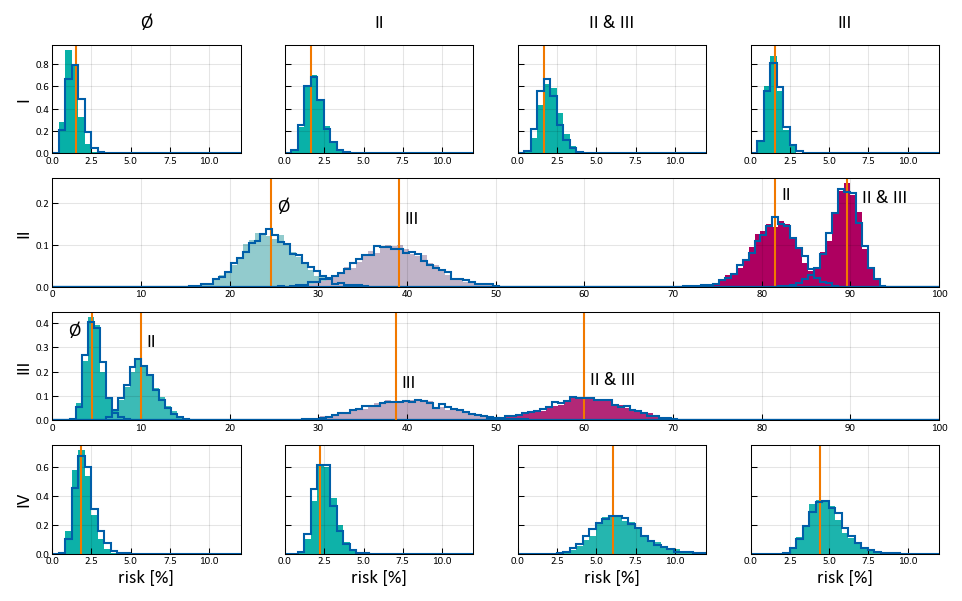

In [21]:
fig = plt.figure(figsize=set_size(width="full"), constrained_layout=True)
spec = gs.GridSpec(ncols=4, nrows=4, figure=fig)

lvls = ["I", "II", "III", "IV"]
txt = ["Ø", "II", "II & III", "III"]
risk_map = LinearSegmentedColormap.from_list("risk_map", [usz_green, 
                                                          usz_gray, 
                                                          usz_red, 
                                                          usz_red], N=256)
n_bins = 25

for i in range(4):
    if (i == 0) or (i == 3):
        bins = np.linspace(0., 12., 30)
        for j in range(4):
            if j == 0:
                ax = fig.add_subplot(spec[i,j])
                ax.set_ylabel(f"{lvls[i]}");
            else:
                ax = fig.add_subplot(spec[i,j], sharey=ax)
                plt.setp(ax.get_yticklabels(), visible=False)
                
            ax.set_xlim(bins[0], bins[-1])
            
            tmp_mean = np.mean(hmm_risk[i,j])
            hmm_color = risk_map(tmp_mean)
            ax.axvline(pouymayou_MLrisk[i,j]*100., 
                       color=usz_orange, label="Pouymayou et al");
            _, bins, _ = ax.hist(hmm_risk[i,j]*100., bins=bins, 
                                 histtype="stepfilled", density=True, 
                                 color=hmm_color) #, label="HMM sampling");
            ax.hist(bn_risk[i,j]*100., bins=bins, density=True, 
                    histtype="step", label="BN sampling", color=usz_blue);
            ax.tick_params(labelsize="xx-small")
            
            if i == 0:
                ax.set_title(f"{txt[j]}", 
                             fontsize="medium", fontweight="normal");
            else:
                ax.set_xlabel("risk [%]");
                
    else:
        ax = fig.add_subplot(spec[i,:])
        bins = np.linspace(0., 100., 150)
        ax.set_xlim(bins[0], bins[-1])
        ax.set_ylabel(f"{lvls[i]}");
        
        for j in range(4):
            tmp_mean = np.mean(hmm_risk[i,j])
            hmm_color = risk_map(tmp_mean)
            ax.axvline(pouymayou_MLrisk[i,j]*100., 
                       color=usz_orange, label="Pouymayou et al");
            n, bins, _ = ax.hist(hmm_risk[i,j]*100., bins=bins, 
                                 histtype="stepfilled", density=True, 
                                 color=hmm_color) #, label="HMM sampling");
            ax.hist(bn_risk[i,j]*100., bins=bins, density=True, 
                    histtype="step", label="BN sampling", color=usz_blue, 
                    linestyle='-');
            ax.set_xticks(np.linspace(0,100, 11))
            ax.tick_params(labelsize="xx-small")
            
            if ((i == 2) and (j == 0)):
                ax.text(x=100*pouymayou_MLrisk[i,j]-4*(bins[1]-bins[0]), 
                        y=0.35, 
                        s=txt[j])
            elif ((i == 1) and (j == 2)):
                ax.text(x=100*pouymayou_MLrisk[i,j]+2.5*(bins[1]-bins[0]), 
                        y=0.2, 
                        s=txt[j])
            else:
                ax.text(x=100*pouymayou_MLrisk[i,j]+(bins[1]-bins[0]), 
                        y=np.max(n)+0.05, 
                        s=txt[j])
                
if SAVE_FIGURES:
    plt.savefig("./figures/HMM_BN_risk_comparison.png", dpi=300, 
                bbox_inches="tight")
    plt.savefig("./figures/HMM_BN_risk_comparison.svg", 
                bbox_inches="tight")

> *__Figure 8:__ Risk assessment for the involvement of different LNLs (rows), given positive observational findings in specified LNLs (columns or labels next to histograms). E.g. row 3 depicts the risk of involvement in LNL III, given different observed involvements (from left to right: no involvement, LNL II only, LNL III only, and LNL II and III but no others). The orange line depicts the maximum likelihood result from [[2]](#pouymayou), the blue outline histogram represents the BN sampling solutions and the solid coloured histograms are the results from the HMM. The colour goes from green (low risk) to red (high risk). Of 200,000 parameter samples, 2% were used to create this plot.*

## Simultaneous Learning
If we learn both the system's parameters AND the center of the time prior at the same time. But the naive way just leads to overfitting and very unrealistic combinations of parameters. So, what we are doing here is fixing the time prior for the early stage learning (and use the sanguineti data with chosen N0-ratio) and learn the probability rates along with the time-prior for the late stage (where the data only consists of N0 / N+ patients).

In [8]:
# abstract representation of the lymphatic network
graph = {('tumor', 'primary')  : ['I', 'II', 'III', 'IV'], 
         ('lnl', 'I')          : ['II'], 
         ('lnl', 'II')         : ['III'], 
         ('lnl', 'III')        : ['IV'], 
         ('lnl', 'IV')         : []}

model = lymph.System(graph=graph)

In [10]:
# define specificity and sensitivity for diagnostic modalities
pathology_spsn = {"path": [1., 1.]}

model.modalities = pathology_spsn
model.patient_data = data

# create late T-stage diagnose matrices
n_late = len(data)
shape = (len(model.state_list), n_late)
model._diagnose_matrices["late"] = np.zeros(shape=shape)

late_n0_num_patients = int(n_late * (1 - (1. / 1.2)))
late_nplus_num_patients = int(n_late / 1.2)

# N0 patients
model._diagnose_matrices["late"][0 , :late_n0_num_patients] = 1.
model._diagnose_matrices["late"][1:, late_n0_num_patients:] = 1.

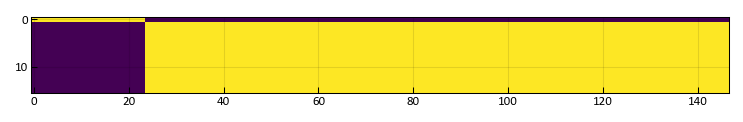

In [11]:
plt.imshow(model.diagnose_matrices["late"])

In [12]:
# define likelihood function for simultaneous learning
def simultaneous_log_likelihood(theta):
    len_spread_probs = len(model.spread_probs)
    spread_probs = theta[:len_spread_probs]
    early_p = 0.4
    late_p = theta[-1]
    
    if late_p > 1. or late_p < 0.:
        return -np.inf
    
    t = np.arange(MAX_T + 1)
    pt = lambda p : sp.stats.binom.pmf(t, MAX_T, p)
    
    time_dists = {}
    time_dists["early"] = pt(early_p)
    time_dists["late"] = pt(late_p)
    
    return model.marginal_log_likelihood(
        spread_probs, ["early", "late"], time_dists=time_dists
    )

In [13]:
theta0 = np.random.uniform(size=(8,))
llh = simultaneous_log_likelihood(theta0)
print(llh)

-1194.137157870604


In [14]:
ndim, nwalker, nstep, burnin = 7 + 1, 200, 2000, 1000
np.random.seed(SEED)
theta0 = np.random.uniform(low=0., high=1., size=(nwalker,ndim))
moves = [(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)]

if DRAW_SAMPLES:
    if __name__ == "__main__":
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(
                nwalker, ndim, 
                simultaneous_log_likelihood, 
                moves=moves, pool=pool
            )
            sampler.run_mcmc(theta0, nstep, progress=True)

    # extracting 200,000 of the 400,000 samples
    samples_simultaneous = sampler.get_chain(flat=True, discard=burnin)

    # saving the sampled data to disk for later convenience
    np.save("./samples/simultaneous.npy", samples_simultaneous)
    
else:
    # loading in case we don't want to draw all the samples again
    samples_simultaneous = np.load("./samples/simultaneous.npy")

100%|██████████| 2000/2000 [01:03<00:00, 31.56it/s]


In [15]:
if DRAW_SAMPLES:
    # check acceptance faction of the sampler to get an indication on whether sth
    # went wrong or not
    ar = np.mean(sampler.acceptance_fraction)
    print(f"the simultaneous sampler accepted {ar * 100 :.2f} % of samples.")

the simultaneous sampler accepted 30.71 % of samples.


findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'monospace' not found because none of the following families were found: Ubuntu Mono


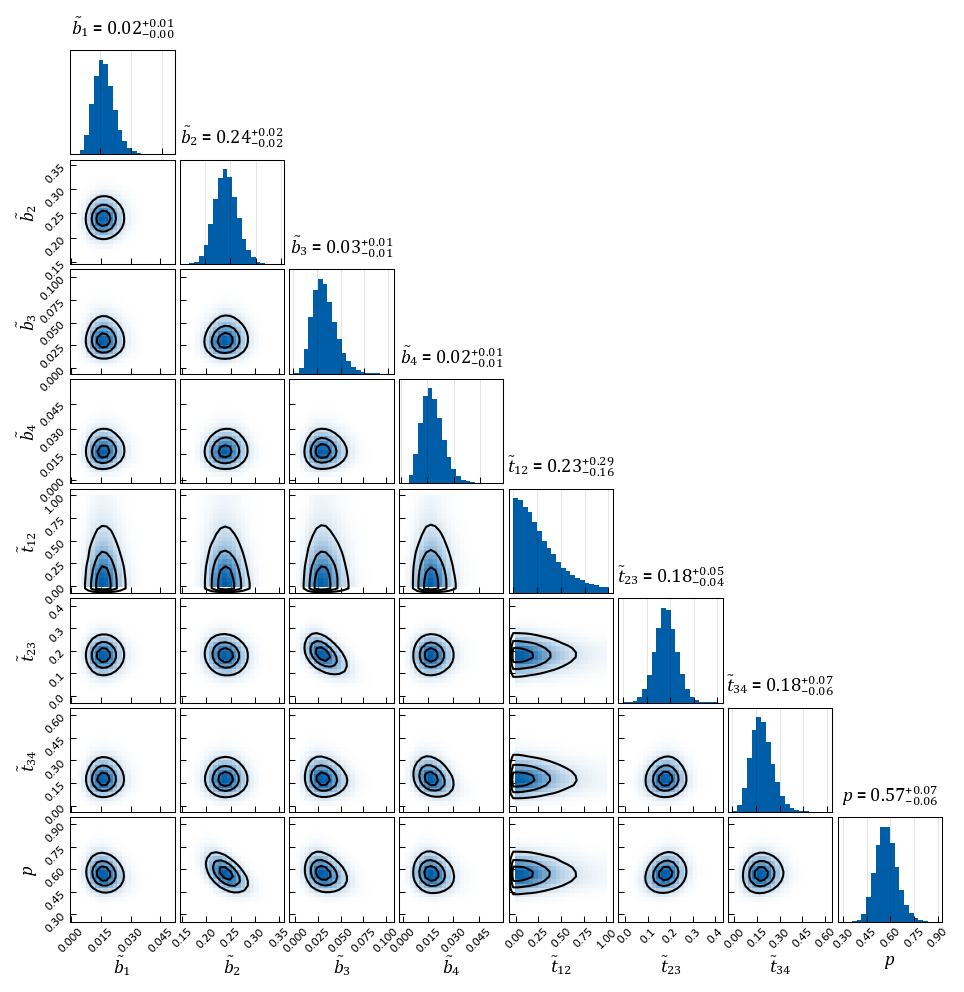

In [16]:
labels = [r"$\tilde{b}_1$", r"$\tilde{b}_2$", 
          r"$\tilde{b}_3$", r"$\tilde{b}_4$", 
          r"$\tilde{t}_{12}$", r"$\tilde{t}_{23}$", 
          r"$\tilde{t}_{34}$", r"$p$"]

fig = plt.figure(figsize=set_size(width="full", ratio=1))
corner.corner(samples_simultaneous, labels=labels, smooth=True, fig=fig, 
              hist_kwargs={'histtype': 'stepfilled', 'color': usz_blue}, 
              **{'plot_datapoints': False, 'no_fill_contours': True, 
                 "density_cmap": white_to_blue.reversed(), 
                 "contour_kwargs": {"colors": "k"}, 
                 "levels": np.array([0.2, 0.5, 0.8])}, 
              show_titles=True, title_kwargs={"fontsize": "medium"});

if SAVE_FIGURES:
    plt.savefig("./figures/corner_simultaneous.png", dpi=300, 
                bbox_inches="tight")
    plt.savefig("./figures/corner_simultaneous.svg", 
                bbox_inches="tight")

> *__Figure 9:__ Corner plot of the sampled paramters during the simultaneous sampling process, were we also inferred the p-parameter of the late T-categorie's time-prior.*

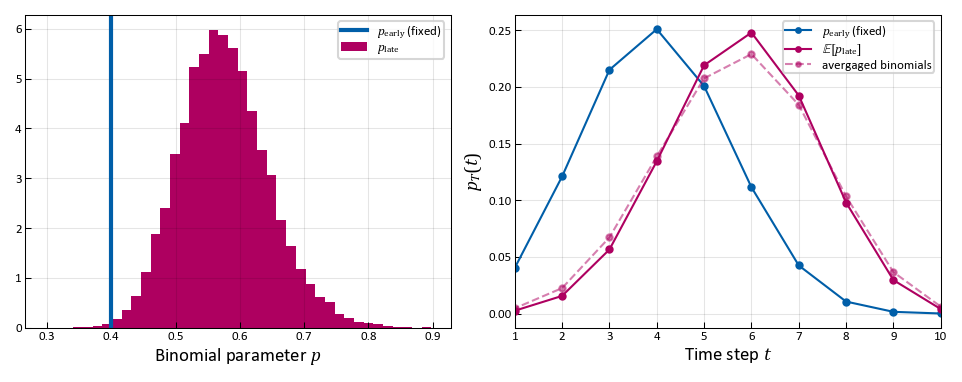

In [17]:
mean_late_p = np.mean(samples_simultaneous[:,7])

fig, ax = plt.subplots(1,2, 
                       figsize=set_size(width="full", ratio=1.61**2), 
                       constrained_layout=True)

ax[0].axvline(0.4, color=usz_blue, linewidth=2, 
              label=r"$p_{\mathrm{early}}$ (fixed)");
ax[0].hist(samples_simultaneous[:,7], bins=40, density=True, 
           color=usz_red, histtype="stepfilled", 
           label=r"$p_{\mathrm{late}}$");
ax[0].set_xlabel("Binomial parameter $p$");
# ax[0].set_ylabel(r"$p\left(\theta_p^T\right)$", fontsize="large");
ax[0].legend();

t = np.arange(MAX_T+1)
dist_sum = np.zeros_like(t, dtype=float)

for sample in np.random.permutation(samples_simultaneous[::100]):
    p = sample[-1]
    dist_sum += sp.stats.binom.pmf(t, MAX_T, p)

dist_avrg = dist_sum / len(samples_simultaneous[::100])

ax[1].plot(t, sp.stats.binom.pmf(t, MAX_T, 0.4), 'o-', 
           label=r"$p_{\mathrm{early}}$ (fixed)");
ax[1].plot(t, sp.stats.binom.pmf(t, MAX_T, mean_late_p), 'o-', color=usz_red, 
           label=r"$\mathbb{E}[p_{\mathrm{late}}]$");
ax[1].plot(t, dist_avrg, 'o--', color=usz_red, alpha=0.5, 
           label="avergaged binomials");

ax[1].legend();
ax[1].set_xlabel("Time step $t$");
ax[1].set_ylabel(r"$p_T(t)$");
ax[1].set_xlim([1,MAX_T]);

if SAVE_FIGURES:
    plt.savefig("./figures/simultaneous_learnedP.png", dpi=300, 
                bbox_inches="tight")
    plt.savefig("./figures/simultaneous_learnedP.svg", 
                bbox_inches="tight")

> *__Figure 10:__ Sampled late T-category p parameter given an early T-category cohort and a fixed fraction of N0 patients (20%) for late T-category (left). Plots of the PMFs of the fixed early T-category binomial distribution, the distribution for the expected value of the late T-category parameter as well as the average distribution resulting from the many sampled binomials (right).*

Now we can again compare risk predictions for different T-stages of disease.

In [18]:
# abstract representation of the lymphatic network
graph = {('tumor', 'primary')  : ['I', 'II', 'III', 'IV'], 
         ('lnl'  , 'I')        : ['II'], 
         ('lnl'  , 'II')       : ['III'], 
         ('lnl'  , 'III')      : ['IV'], 
         ('lnl'  , 'IV' )      : []}

tst_systm = lymph.System(graph=graph)
tst_systm.modalities = {"CT": [0.76, 0.81]}

In [21]:
np.random.seed(SEED)
subset = np.random.permutation(samples_simultaneous[::20])
nsubset = len(subset)
risk_III = np.zeros(shape=(4, nsubset))
risk_IV = np.zeros(shape=(4, nsubset))

inv_III = np.array([None, None, 1, None])
obs_III = np.array([[0, 0, 0, 0],   # no involvement in lvl II observed
                    [0, 1, 0, 0]])  # involvement observed

inv_IV = np.array([None, None, None, 1])
obs_IV = np.array([[0, 0, 0, 0], 
                   [0, 1, 1, 0]])

for i, th in enumerate(subset):
    tst_systm.spread_probs = th[:7]
    prior = np.vstack([sp.stats.binom.pmf(np.arange(MAX_T+1), MAX_T, 0.4), 
                       sp.stats.binom.pmf(np.arange(MAX_T+1), MAX_T, th[7])])
    
    for k in range(4):
        risk_III[k,i] = tst_systm.risk(
            inv=inv_III, diagnoses={"CT": obs_III[k % 2]}, 
            time_dist=prior[k // 2]
        )
        risk_IV[k,i] = tst_systm.risk(
            inv=inv_IV, diagnoses={"CT": obs_IV[k % 2]}, 
            time_dist=prior[k // 2]
        )

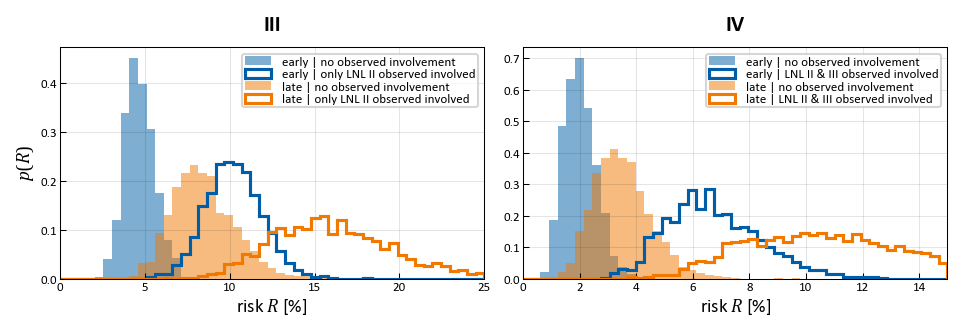

In [22]:
fig, ax = plt.subplots(1,2, 
                       figsize=set_size(width="full", ratio=2*1.5), 
                       constrained_layout=True)
kwargs = [{"histtype": "stepfilled", "alpha": 0.5}, 
          {"histtype": "step", "linewidth": 1.5}]
colors = [usz_blue, usz_orange]
time_label = ["early", "late"]
inv_III_label = ["no observed involvement", 
                 "only LNL II observed involved"]
inv_IV_label = ["no observed involvement", 
                "LNL II & III observed involved"]

for k in range(4):
    bins = np.linspace(0., 25., 50)
    ax[0].hist(100*risk_III[k], bins=bins, density=True, 
               color=colors[k // 2], **kwargs[k % 2], 
               label=f"{time_label[k // 2]} | {inv_III_label[k % 2]}")
    ax[0].set_xlabel("risk $R$ [%]");
    ax[0].set_ylabel(r"$p(R)$");
    ax[0].set_xlim([bins[0], bins[-1]])
    ax[0].legend()
    ax[0].set_title("III")
    
    bins = np.linspace(0., 15., 50)
    ax[1].hist(100*risk_IV[k], bins=bins, density=True, 
               color=colors[k // 2], **kwargs[k % 2], 
               label=f"{time_label[k // 2]} | {inv_IV_label[k % 2]}")
    ax[1].set_xlabel("risk $R$ [%]");
    ax[1].set_xlim([bins[0], bins[-1]]);
    ax[1].legend()
    ax[1].set_title("IV")
    
if SAVE_FIGURES:
    plt.savefig("./figures/simultaneous_risk.png", dpi=300, 
                bbox_inches="tight")
    plt.savefig("./figures/simultaneous_risk.svg", 
                bbox_inches="tight")

> *__Figure 11:__ Distributions over risk of involvement for LNL III (left) and LNL IV (right), each for early and late T-category as well as depending on the given observed involvement. The sampled parameters displayed here are a randomly selected subset (1% of 200,000) from simultaneous learning. Comparison with Fig. 8 shows that these predictions still agree with the results from the early stage only learning.*

## References
1. <a class="anchor" id="sanguineti"></a>Sanguineti Giuseppe [et al.] Defining the risk of involvement for each neck nodal level in patients with early T-stage node-positive oropharyngeal carcinoma. [Journal] // International Journal of Radiation Oncology Biology Physics. - 2008. - 5 : Vol. 74. - pp. 1356-1364.
2. <a class="anchor" id="pouymayou"></a>Pouymayou Bertrand [et al.] A Bayesian network model of lymphatic tumor progression for personalized elective CTV definition in head and neck cancers [Journal] // Physics in Medicine and Biology. - 2019. - 16 : Vol. 64. - p. 165003.

## Appendix

### t-Dependence of Rates

Since the HMM-formalism has more parameters than the BN through its time prior, we expect the system to be somewhat overdetermined. In our case this means that we can basically choose an arbitrary number of time steps and the base and transition probability rates will essentially adapt to our choice. To see *how* the rates depend on the time prior's length we'll look at a simplistic example:

For the simplest example, the time prior $p_T(t,T)=1 / T$ is uniform and we're only looking at a system with one node that has empirically an involvement probability of $p^*$ (e.g. $0.4$), the base probability rate $p$ must become smaller, as the length of the uniform prior increases. More formally,

$$
\begin{align}
p^* 
&= \sum_{t=1}^{T}{\frac{1}{T}\begin{pmatrix} 1 & 0 \end{pmatrix}\begin{bmatrix} 1-p & p \\ 0 & 1 \end{bmatrix}^t\begin{pmatrix} 0 \\ 1 \end{pmatrix}} \\
&= \sum_{t=1}^{T}{\frac{1}{T}\begin{pmatrix} 1 & 0 \end{pmatrix}\begin{bmatrix} (1-p)^t & 1-(1-p)^t \\ 0 & 1 \end{bmatrix}\begin{pmatrix} 0 \\ 1 \end{pmatrix}} \\
&= \sum_{t=1}^{T}{\frac{1}{T}\sum_{k=1}^{t}{{t\choose k}p^k(1-p)^{t-k}}}
= \sum_{t=1}^{T}{\frac{1}{T}\left[ 1 - (1-p)^t \right]} \\
&= 1 - \frac{1}{T}\sum_{t=1}^{T}{(1-p)^t}
\end{align}
$$

Let's write $q = 1 - p$ and then the sum as

$$
s = \sum_{t=1}^{T}{q^t} = q + q^2 + \ldots + q^T
$$

hence

$$
q\cdot s = q^2 + q^3 + \ldots + q^{T+1}
$$

and

$$
\begin{align}
s - qs &= q - q^{T+1} \\
\Rightarrow\, s(1 - q) &= q(1 - q^T) \\
\Rightarrow\, s &= \frac{q(1 - q^T)}{1 - q}
\end{align}
$$

So we can write the empirical probability $p^*$ as

$$
p^* = 1 - \frac{q(1 - q^T)}{T(1 - q)} = 1 - \frac{(1-p)(1 - (1-p)^T)}{Tp}
$$

This cannot be solved analytically for $p$ in the case of arbitrary $T$, but it is easy to find numerical solutions.

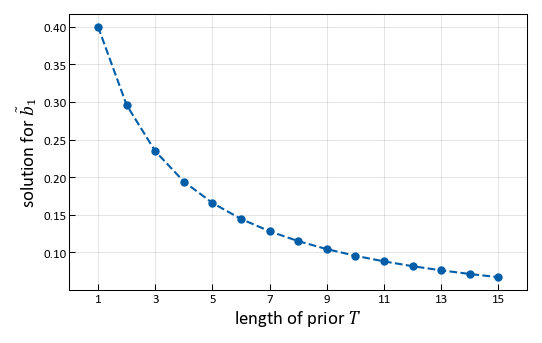

In [69]:
p_star = 0.4
max_prior_length = 15

Ts = np.linspace(1, max_prior_length, max_prior_length, dtype=int)
f = lambda p,t,p_star : 1 - (1 - p)*(1 - (1-p)**t) / (t*p) - p_star

sols = []
for t in Ts:
    # find roots of f numerically
    sols.append(sp.optimize.root_scalar(f, args=(t,p_star), bracket=[0.001, 0.999]).root)
    
# plot the computed solutions
fig, ax = plt.subplots(figsize=set_size())
ax.plot(Ts, sols, 'o--');
ax.set_xlim([0, max_prior_length+1]);
ax.set_xticks(Ts[::2]);
ax.set_xlabel("length of prior $T$");
ax.set_ylabel(r"solution for $\tilde{b}_1$");

if SAVE_FIGURES:
    plt.savefig("./figures/simple_rate_decay.png", dpi=300, 
                bbox_inches="tight")
    plt.savefig("./figures/simple_rate_decay.svg", 
                bbox_inches="tight")

To see if this overly simplified model applies to the full HMM as well, we trained our model for 15 different uniform time priors and plotted the learned mean parameters. We also compared the risk predictions using these different time priors.

In [72]:
# sampling parameters
ndim, nwalker, nstep, burnin = 7, 200, 2000, 1000
moves = [(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)]

# starting point
np.random.seed(SEED)
theta0 = np.random.uniform(low=0., high=1., size=(nwalker,ndim))
prior_dict = {}

samples_multiT_HMM = np.zeros(shape=(max_prior_length, 
                                     nwalker*(nstep-burnin), 
                                     ndim))

for i in range(max_prior_length):
    if DRAW_SAMPLES:
        if __name__ == "__main__":
            with Pool() as pool:
                # uniform time prior of varying length
                prior_dict['early'] = np.concatenate([[0.], [1./(i+1)]*(i+1)])

                sampler = emcee.EnsembleSampler(nwalker, ndim, systm.likelihood, 
                                                args=[['early'], prior_dict], 
                                                kwargs={"mode": "HMM"},
                                                moves=moves, pool=pool)
                sampler.run_mcmc(theta0, nstep, progress=True)

                # store the i-th sampling round
                samples_multiT_HMM[i] = sampler.get_chain(flat=True, 
                                                          discard=burnin)

        # saving the sampled data to disk for later convenience
        np.save(f"./samples/multiT_HMM_{i}.npy", samples_multiT_HMM[i])
        
    else:
        # loading in case we don't want to draw all the samples again
        samples_multiT_HMM[i] = np.load(f"./samples/multiT_HMM_{i}.npy")

Plot the results vs the theoretical values. This is only applicable to the base probability rates $\tilde{b}_1$ and $\tilde{b}_2$, since all other LNL's probability rates are also influenced by other efferent spread pathways.

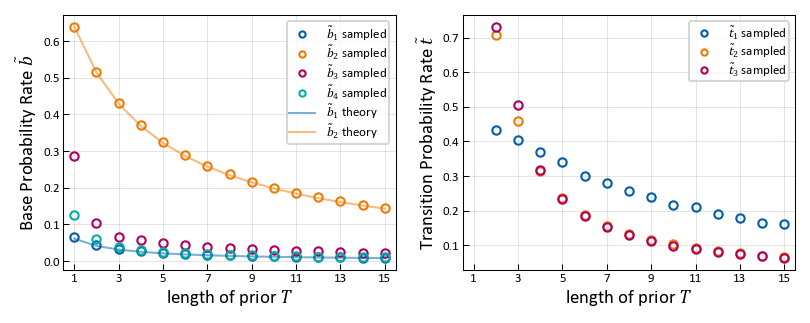

In [34]:
# compute mean and variance of sampled parameters
multiT_b = [np.mean(samples_multiT_HMM[:,:,i], axis=1) for i in range(4)]
multiT_b_var = [np.var(samples_multiT_HMM[:,:,i], axis=1) for i in range(4)]
multiT_t = [np.mean(samples_multiT_HMM[1:,:,i], axis=1) for i in range(4,7)]
multiT_t_var = [np.var(samples_multiT_HMM[1:,:,i], axis=1) for i in range(4,7)]

# plot
fig, ax = plt.subplots(1,2, figsize=set_size("full", ratio=2.8))

# plot base prob sample means for differently lengthed time priors
for i in range(4):
    ax[0].plot(range(1,max_prior_length+1), multiT_b[i], "o", mfc="none", ms=4, 
               label=f"$\\tilde{{b}}_{{{i+1}}}$ sampled");

# prevalence of involvement in LNL I and II
prevalence_I = np.sum(data[("path", "I")].to_numpy()) / len(data)
prevalence_II = np.sum(data[("path", "II")].to_numpy()) / len(data)
theory_roots = np.zeros(shape=(2,max_prior_length))

# compute roots with P^* = prevalence
for t in range(1,max_prior_length+1):
    theory_roots[0,t-1] = sp.optimize.root_scalar(f, 
                                                  args=(t, prevalence_I), 
                                                  bracket=[0.001, 0.999]).root
    theory_roots[1,t-1] = sp.optimize.root_scalar(f, 
                                                  args=(t, prevalence_II), 
                                                  bracket=[0.001, 0.999]).root

# plot theoretical roots
ax[0].plot(range(1,max_prior_length+1), theory_roots[0], "-", alpha=0.5, 
           label=r"$\tilde{b}_{1}$ theory");
ax[0].plot(range(1,max_prior_length+1), theory_roots[1], "-", alpha=0.5, 
           label=r"$\tilde{b}_{2}$ theory");

offset = 0.5
ax[0].set_xlim([1 - offset, max_prior_length + offset]);
ax[0].set_xticks(np.arange(1, max_prior_length+1, 2))
ax[0].set_xlabel("length of prior $T$");
ax[0].set_ylabel(r"Base Probability Rate $\tilde{b}$");
ax[0].legend(ncol=1);


# plot trans prob sample means
# plot sample means for differently lengthed time priors
for i in range(3):
    ax[1].plot(range(2,max_prior_length+1), multiT_t[i], "o", mfc="none", ms=4, 
               label=f"$\\tilde{{t}}_{{{i+1}}}$ sampled");
    
offset = 0.5
ax[1].set_xlim([1 - offset, max_prior_length + offset]);
ax[1].set_xticks(np.arange(1, max_prior_length+1, 2))
ax[1].set_xlabel("length of prior $T$");
ax[1].set_ylabel(r"Transition Probability Rate $\tilde{t}$");
ax[1].legend(ncol=1);

if SAVE_FIGURES:
    plt.savefig("./figures/rate_decay_theory_vs_sampled.png", dpi=300, 
                bbox_inches="tight")
    plt.savefig("./figures/rate_decay_theory_vs_sampled.svg", 
                bbox_inches="tight")

These plots show that the probability rates of a more complex and realistic system qualitatively follow the same behaviour as the example with only one node. This serves as an argument why we can essentially choose the length of the prior as it suits us.

Finally, let's check if the risk actually changes:

In [73]:
# abstract representation of the lymphatic network
graph = {('tumor', 'primary')  : ['I', 'II', 'III', 'IV'], 
         ('lnl', 'I')          : ['II'], 
         ('lnl', 'II')         : ['III'], 
         ('lnl', 'III')        : ['IV'], 
         ('lnl', 'IV')         : []}

systm = lymph.System(graph=graph)

# set specificity & sensitivity of diagnostic modality (here CT) manually
ct_spsn = {"CT": [0.76, 0.81]}
systm.modalities = ct_spsn

In [74]:
# what do we want to know, what do we know?
inv = np.array([None, None, 1, None])  # we're interested in the risk of lvl 3 being involved
# our observation is that lvl 2 is involved
obs = {"CT": np.array([0, 1, 0, 0])}

np.random.seed(SEED)
ndim, nwalker, nstep, burnin = 7, 200, 2000, 1000
thin = 200
time_dists = {}
hmm_risk = np.zeros(shape=(max_prior_length, (nstep-burnin)*nwalker//thin))

for k in range(max_prior_length):
    # time priors
    time_dists['early'] = np.concatenate([[0.], [1./(k+1)] * (k+1)])

    # risk for HMM and two different "T-stages" (early and late)
    subset = np.random.permutation(samples_multiT_HMM[k])[::thin]
    for i, sample in enumerate(subset):
        systm.spread_probs = sample
        hmm_risk[k, i] = systm.risk(
            inv=inv, diagnoses=obs, 
            time_dist=time_dists["early"], mode="HMM"
        )

In [48]:
bn_risk = np.zeros(shape=(len(samples_BN) // thin))
for i, sample in enumerate(np.random.permutation(samples_BN)[::thin]):
    systm.spread_probs = sample
    bn_risk[i] = systm.risk(inv=inv, diagnoses=obs, mode="BN")

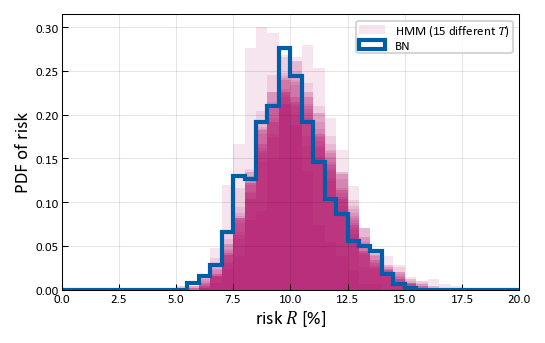

In [49]:
fig, ax = plt.subplots(figsize=set_size())

ax.hist(100*hmm_risk[0], bins=100, range=[0., 50], density=True, 
        color=usz_red, alpha=0.1, label=f"HMM ({max_prior_length} different $T$)")
[ax.hist(100*hmm_risk[k], bins=100, range=[0., 50], density=True, 
         color=usz_red, alpha=0.1) for k in np.arange(1,max_prior_length)];
ax.hist(100*bn_risk, histtype="step", bins=100, linewidth=2, range=[0., 50], 
        density=True, label="BN");
ax.set_xlim([0., 20]);
ax.legend();
ax.set_xlabel(r"risk $R$ [%]");
ax.set_ylabel("PDF of risk");

if SAVE_FIGURES:
    plt.savefig("./figures/multi_length_risk.png", dpi=300, 
                bbox_inches="tight")
    plt.savefig("./figures/multi_length_risk.svg", 
                bbox_inches="tight")

The risk for all the HMMs is the same, except for the one that only includes one time step. The reason for this is that when the system is not given the time to spread, it cannot correctly estimate the conditional risks of what would happen if the previous node was involved vs if it was not involved. So the HMM that is "too short" overestimates the risk due to the high prevalence of LNL III's involvement.